# Titanic

In [228]:
#import data minuplations modules
import pandas as pd
import numpy as np

#import viuslaization models
import matplotlib.pyplot as plt
import seaborn as sns

#import normalization modules
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#import preprocessing train_test_split module
# from sklearn.model_selection import train_test_split # Do not need this with the multiple datasets kaggle has given

#import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC

#import NN models - Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#import NN models - Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

#import accuracy_score function from sklearn.metrics to score models better
from sklearn.metrics import accuracy_score


In [229]:
#load the data into dataframes
#data retrieved from kaggle competitions
train = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

In [230]:
#Merge the gender_submission database and the test_df database since they were given by kaggle
#but contain incomplete data in comparision to the train dataframe. This merge consolidates for further manipulation
test = pd.merge(test_df, gender_submission, on = "PassengerId", how="inner")
test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


Going to need to apply any column changes to test and train. gender_submissions will be what we apply at the end with passenger IDs matching

In [231]:
#Dummies variables for PClass to prevent bias toward one number being weighed more than another
train = pd.concat([train, pd.get_dummies(train["Pclass"], prefix='Pclass')], axis=1)
test = pd.concat([test, pd.get_dummies(test["Pclass"], prefix='Pclass')], axis=1)

# Let's make the sex cloumn into a binary column
train['Sex_binary'] = train.Sex.map({"male": 0, "female": 1}) 
test['Sex_binary'] = test.Sex.map({"male": 0, "female": 1})

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_binary
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0


In [232]:
# We need to turn the Pclass into its own columns in order to get a better prediction on who will be in what class
# train['FirstClass'] = train.Pclass.apply(lambda p: 1 if p == 1 else 0)
# test['FirstClass'] = test.Pclass.apply(lambda p: 1 if p == 1 else 0)
# train.head()
# Now the same thing for second class and then again for third class people. 
# We need to turn the Pclass into its own columns in order to get a better prediction on who will be in what class
# train['SecondClass'] = train.Pclass.apply( lambda p: 1 if p == 2 else 0)
# test['SecondClass'] = test.Pclass.apply( lambda p: 1 if p == 2 else 0)
# train.head(10)
# train['ThirdClass'] = train.Pclass.apply( lambda p: 1 if p == 3 else 0)
# test['ThirdClass'] = test.Pclass.apply( lambda p: 1 if p == 3 else 0)
# train.head()

We know from stories of Titanic that women and children  can be saved in a life raft, but what about men? 
I think we should address gender and age next as it may help our model. 

I could of done this earlier, but in this data, I am not likely to use the following columns right now. I may need them later for further analysis but at present they are just cluttering up my dataset. Lets just drop them for now from each dataframe.

Pclass, Name, SibSp, Parch, Ticket, Fare, Cabin, Embarked

In [233]:
# columns_to_drop = ["Pclass", "Name", "Sex", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
columns_to_drop = ["Pclass", "Name", "Sex",  "Ticket", "Cabin", "Embarked"]

train = train.drop(columns_to_drop, axis = 1)
test = test.drop(columns_to_drop, axis = 1)
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_binary
0,1,0,22.0,1,0,7.2500,0,0,1,0
1,2,1,38.0,1,0,71.2833,1,0,0,1
2,3,1,26.0,0,0,7.9250,0,0,1,1
3,4,1,35.0,1,0,53.1000,1,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0


In [234]:
train.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_binary
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208,0.242424,0.206510,0.551066,0.352413
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429,0.428790,0.405028,0.497665,0.477990
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


## Types of missing data:
- **Missing Completely at Random (MCAR):** No pattern to the missingness.
- **Missing at Random (MAR):** Missingness might be related to other observed variables, but not the missing value itself.
- **Missing Not at Random (MNAR):** The missingness depends on the value of the missing data itself.

## Strategies for Handling Missing Values

- **Listwise Deletion:** Remove rows containing missing values. Use with caution, especially if you have a large number of missing entries, as you could lose valuable information.
- **Pairwise Deletion:** Utilize all available data, but computations might involve different subsets of data.
- **Imputation:** Fill in missing values with estimated substitutes. **Common methods:**
- **Mean/Median Imputation:** Replace missing values with the mean/median of the column. Suitable for numerical data.
- **Mode Imputation:** Replace missing categorical values with the most frequent category.
- **Predictive Modeling:** Create a model to predict missing values based on other variables. This can be more sophisticated.


This is an exert summary from google's Gemini

In [235]:

#Let's fill in the ages with the mean of all ages.
train['Age'].fillna(value = round(train['Age'].mean()), inplace = True) #look up .fillna function
test['Age'].fillna(value = round(test['Age'].mean()), inplace = True) 
train["Age"].count() #now we have every row accounted for. 
test["Fare"].dropna(axis=0, how='any', inplace=True)
test['Fare'].fillna(value = round(test['Fare'].mean()), inplace = True) 

# Prepare the data
 We were given two datasets so we will split them accordingly. WIth one dataset we would use the train_test_split function from the model selection of sklearn. 

In [236]:
#I want to focus on training a model on Age, Sex_binary, FirstClass, SecondClass, ThirdClass, "SibSp", "Parch", "Fare"
#The goal is to predict whether or not the user survived based on this. 
train_features = train[["Age", "Sex_binary", "Pclass_1","Pclass_2", "Pclass_3", "Fare"]]
train_labels = train["Survived"]
test_features = test[["Age", "Sex_binary", "Pclass_1", "Pclass_2", "Pclass_3", "Fare"]]
test_labels = gender_submission["Survived"]


In [237]:
#initialize an accuracy test key = model , value = accuracy score
model_accuracy_titanic_compare = {}

Now we will normalize the data in preparation for loading and training the model. This allows all weighst to be evenly distriubted

In [238]:
# Scale the feature data so it has mean = 0 and standard deviation = 1
scaler = StandardScaler()
train_features_Scalar = scaler.fit_transform(train_features)
test_features_Scalar = scaler.transform(test_features)

In [287]:
scaler = MinMaxScaler()
train_features_MinMax = scaler.fit_transform(train_features)
test_features_MinMax = scaler.transform(test_features)

# Start Logistic Regression 

In [239]:
model = LogisticRegression()
model.fit(train_features_Scalar, train_labels)

LogisticRegression()

In [240]:
# print(model.score(train_features, train_labels)) #I Switched to the metric module for accuracy_score
y_predict = model.predict(test_features_Scalar)

LR_model_acc_score = accuracy_score(test_labels, y_predict)
model_accuracy_titanic_compare["Logistic Rregression model:"] = LR_model_acc_score
print(f"Accuracy: {LR_model_acc_score}")

Accuracy: 0.9641148325358851


In [241]:
#lets see the coefficents -  Age, Sex_binary, "Pclass_1","Pclass_2", "Pclass_3", Fare
print(model.coef_)


[[-0.42201752  1.23270086  0.52596512  0.0671699  -0.50784064  0.03996974]]


Coefficients represent the relationship between each feature (variable) and the log-odds of the target event

A positive coefficient means that an increase in the feature's value is associated with a higher likelihood of survival.

A negative coefficient means that an increase in the feature's value is associated with a lower likelihood of survival.

- Age =        -0.42201752   
- Sex_binary =  1.23270086      
- PClass_1 =    0.52596512 
- PClass_2 =    0.0671699   
- PClass_3 =   -0.50784064
- Fare =        0.03996974


In [242]:
#I remember when I did this 2 years ago, we used Jack and Rose then ourselves to make predictions on the model and we mad ethem in a np.array
Jack = np.array([20.0, 0.0, 0.0, 0.0, 1.0, 8.0500])
Rose = np.array([17.0, 1.0, 1.0, 0.0, 0.0, 71.2833])
Dom = np.array([29.0,  0.0, 0.0, 1.0, 0.0, 30.0708])

In [243]:
passenger_predict = np.array([Jack, Rose, Dom])

In [244]:
passenger_predict = scaler.transform(passenger_predict)

C:\Users\pc\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


That warning again?..

In [245]:
#prediction time! My favorite part
# Make survival predictions!
print(model.predict(passenger_predict)) #This will print a 1 or 0 for surivied or did not survive 
print(model.predict_proba(passenger_predict)) #this will give us how likely for each option

[0 1 0]
[[0.88575431 0.11424569]
 [0.05074167 0.94925833]
 [0.75688652 0.24311348]]


- Jack had an 88.5% of NOT surviving based on the data. 
- Rose had a 95% chance of surviving. 
- Dom would of had a 75.9% chance of NOT surviving.

# Start Decision Tree model

We have the option of using DecisionTreeClassifier or DecisionTreeRegressor.

We know that we are classifying whether or not someone survived so we should use the DecisionTreeClassifier. 

In [246]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [247]:
#does not need normalized data
tree_model.fit(train_features_Scalar, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [248]:
y_predict = tree_model.predict(test_features_Scalar)

tree_model_acc_score = accuracy_score(test_labels, y_predict)
model_accuracy_titanic_compare["Decision Tree model:"] = tree_model_acc_score
print(f"Accuracy: {tree_model_acc_score}")

Accuracy: 0.9617224880382775


In [249]:
# passenger_predict
print(tree_model.predict(passenger_predict))
print(tree_model.predict_proba(passenger_predict))

[0 1 0]
[[0.8975     0.1025    ]
 [0.02       0.98      ]
 [0.67721519 0.32278481]]


# Start Random Forest Classifier

In [250]:
RFC_model = RandomForestClassifier(n_estimators=90, criterion='gini', max_depth=5)

In [251]:
RFC_model.fit(train_features_Scalar, train_labels)

RandomForestClassifier(max_depth=5, n_estimators=90)

In [252]:
y_predict_RFC = RFC_model.predict(test_features_Scalar)

In [253]:
#Now it should of predicted if it thinks the people in the test_features dataset survived. Lets compare that to our information of their actual survival rates

rfl_acc = accuracy_score(test_labels, y_predict_RFC)

model_accuracy_titanic_compare["Random Forrect Classifier model:"] = rfl_acc

print("Accuracy:", accuracy_score(test_labels, y_predict_RFC))

Accuracy: 0.8827751196172249


In [254]:
# passenger_predict
print(RFC_model.predict(passenger_predict))
print(RFC_model.predict_proba(passenger_predict))

[0 1 0]
[[0.86193575 0.13806425]
 [0.03277286 0.96722714]
 [0.81102691 0.18897309]]


# Next we will go over Naive Bayes for Classification


In [255]:
#We should not need to do much for this one
nb_model = GaussianNB()

In [256]:
nb_model.fit(train_features_Scalar, train_labels)

GaussianNB()

In [257]:
y_predict_NB = nb_model.predict(test_features_Scalar)

NB_acc_score = accuracy_score(test_labels, y_predict_NB)
model_accuracy_titanic_compare["Naive Bayes Classifier model:"] = NB_acc_score
print(f"Accuracy: {NB_acc_score}")

Accuracy: 0.7655502392344498


In [258]:
# passenger_predict
print(nb_model.predict(passenger_predict))
print(nb_model.predict_proba(passenger_predict))

[0 1 0]
[[0.98184197 0.01815803]
 [0.00758405 0.99241595]
 [0.8395652  0.1604348 ]]


# KNN

In [259]:
knn_model = KNeighborsClassifier(n_neighbors=5) 

In [260]:
knn_model.fit(train_features_Scalar, train_labels)

KNeighborsClassifier()

In [261]:
y_predict = knn_model.predict(test_features_Scalar)

knn_acc = accuracy_score(test_labels, y_predict)
model_accuracy_titanic_compare["K Nearest Neighbor model:"] = knn_acc
knn_acc

0.868421052631579

# Support Vector Machine - Classifer

In [262]:
svm_svc_model = svm.SVC(kernel='poly', C=1.5) 

In [263]:
svm_svc_model.fit(train_features_Scalar, train_labels)

SVC(C=1.5, kernel='poly')

In [264]:
y_predict_svm = svm_svc_model.predict(test_features_Scalar)

svm_acc = accuracy_score(test_labels, y_predict_svm)
model_accuracy_titanic_compare["Support Vector Classifier model:"] = svm_acc
svm_acc

0.9665071770334929

# Nueral Networks - Pytorch

In [265]:
#What version am I on?
torch.__version__

'1.12.1+cpu'

In [266]:
type(train_labels)

pandas.core.series.Series

In [271]:
train_features_pre_normalized = train[["Age", "Sex_binary", "Pclass_1", "Pclass_2", "Pclass_3", "Fare"]]
train_labels_pre_normalized = train["Survived"]
test_features_pre_normalized = test[["Age", "Sex_binary", "Pclass_1", "Pclass_2", "Pclass_3", "Fare"]]
test_labels_pre_normalized = gender_submission["Survived"]


In [272]:
# Convert data to PyTorch tensors
train_features_pt = torch.tensor(train_features_pre_normalized.values).float()
# train_labels = torch.tensor(train_labels_pre_normalized.values).float()
test_features_pt = torch.tensor(test_features_pre_normalized.values).float()
# test_labels = torch.tensor(test_labels_pre_normalized.values).float()


# Convert labels to NumPy arrays
train_labels_np = train_labels.values
test_labels_np = test_labels.values

# Convert to PyTorch tensors with explicit dtype
train_labels_pt = torch.tensor(train_labels_np, dtype=torch.long)
test_labels_pt = torch.tensor(test_labels_np, dtype=torch.long)


# Create TensorDatasets
train_dataset = TensorDataset(train_features_pt, train_labels_pt)
test_dataset = TensorDataset(test_features_pt, test_labels_pt)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



C:\Users\pc\AppData\Local\Temp\ipykernel_5168\2508534257.py:2: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  train_features_pt = torch.tensor(train_features_pre_normalized.values).float()


In [273]:
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define network dimensions
input_size = train_features_pt.shape[1]
hidden_size = 10  # You can adjust this
output_size = 2  # Two classes: Survived or Not Survived

# Create the network
PyTorchmodel = TitanicNN(input_size, hidden_size, output_size)


In [274]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(PyTorchmodel.parameters(), lr=0.001)


In [275]:
num_epochs = 100  # adjust this
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = PyTorchmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')


Epoch 1/100, Loss: 0.7728467839104789
Epoch 2/100, Loss: 0.6509943391595568
Epoch 3/100, Loss: 0.6116829769951957
Epoch 4/100, Loss: 0.6091484980923789
Epoch 5/100, Loss: 0.6023237960679191
Epoch 6/100, Loss: 0.598874398640224
Epoch 7/100, Loss: 0.5966017629419055
Epoch 8/100, Loss: 0.5954499947173255
Epoch 9/100, Loss: 0.5933724769524166
Epoch 10/100, Loss: 0.5933330995695931
Epoch 11/100, Loss: 0.5910523022924151
Epoch 12/100, Loss: 0.588396532194955
Epoch 13/100, Loss: 0.5869190373591014
Epoch 14/100, Loss: 0.585957910333361
Epoch 15/100, Loss: 0.5825032123497554
Epoch 16/100, Loss: 0.5807785008634839
Epoch 17/100, Loss: 0.578188738652638
Epoch 18/100, Loss: 0.5755171009472438
Epoch 19/100, Loss: 0.5688919510160174
Epoch 20/100, Loss: 0.5619595944881439
Epoch 21/100, Loss: 0.5554712755339486
Epoch 22/100, Loss: 0.5515387526580265
Epoch 23/100, Loss: 0.5513582846948079
Epoch 24/100, Loss: 0.5457785299846104
Epoch 25/100, Loss: 0.5418071533952441
Epoch 26/100, Loss: 0.5360519226108279

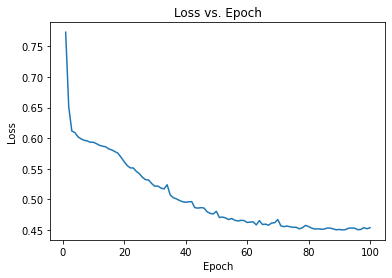

In [276]:
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()


In [277]:
PyTorchmodel.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = PyTorchmodel(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
model_accuracy_titanic_compare["Pytorch Neural Network model:"] = accuracy
print(f'Accuracy on test set: {accuracy * 100}%')


Accuracy on test set: 90.43062200956938%


In [278]:
#Predict time!!
passenger_predict_tensor = torch.tensor(passenger_predict).float()

with torch.no_grad():
    outputs = PyTorchmodel(passenger_predict_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

In [279]:
# Set the PyTorchmodel to evaluation mode
PyTorchmodel.eval()

# Make predictions
with torch.no_grad():
    outputs = PyTorchmodel(passenger_predict_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

# Convert predictions and probabilities to numpy arrays for easy printing
predictions_np = predictions.tolist()
probabilities_np = probabilities.tolist()

# Print results
print(predictions_np)
probabilities_np


[0, 1, 0]


[[0.605410099029541, 0.39458999037742615],
 [0.010788870975375175, 0.9892110824584961],
 [0.5447672009468079, 0.45523279905319214]]

# Tensorflow 

In [324]:
# Convert data to TensorFlow tensors
train_features_tf = tf.convert_to_tensor(train_features.values, dtype=tf.float32)
train_labels_tf = tf.convert_to_tensor(train_labels.values, dtype=tf.int64)
test_features_tf = tf.convert_to_tensor(test_features.values, dtype=tf.float32)
test_labels_tf = tf.convert_to_tensor(test_labels.values, dtype=tf.int64)

# Define network dimensions
input_size = train_features_pt.shape[1]
hidden_size = 12  # You can adjust this
output_size = 2  # Two classes: Survived or Not Survived


In [325]:
# make the nn
model_tf = models.Sequential([
    layers.Dense(hidden_size, activation='relu', input_shape=(input_size,)),
    layers.Dense(output_size, activation='softmax')
])

# model_tf = models.Sequential([
#     layers.Dense(hidden_size, activation='relu', input_shape=(input_size,), kernel_regularizer='l2'),
#     layers.Dropout(0.3), 
#     layers.Dense(16, activation='relu', kernel_regularizer='l2'), 
#     layers.Dense(output_size, activation='softmax')
# ])


In [326]:
# compile the model here
model_tf.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Assuming labels are not one-hot encoded
#                 metrics=['accuracy'])


In [329]:
#model train
history = model_tf.fit(train_features_tf, train_labels_tf, epochs=200, batch_size=batch_size, verbose=1)


Epoch 1/200
 1/14 [=>............................] - ETA: 0s - loss: 0.3404 - accuracy: 0.8594

14/14 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.8025
Epoch 2/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.8081
Epoch 3/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4471 - accuracy: 0.8025
Epoch 4/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4475 - accuracy: 0.8002
Epoch 5/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.8126
Epoch 6/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4499 - accuracy: 0.8036
Epoch 7/200
14/14 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.7991
Epoch 8/200
14/14 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.8013
Epoch 9/200
14/14 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.8081
Epoch 10/200
14/14 [==============================] - 0s 1ms/step - loss: 0.4469 - accuracy: 0.8081
Epoch 11/200
14/14 [=

In [330]:
loss, accuracy = model_tf.evaluate(test_features_tf, test_labels_tf)
model_accuracy_titanic_compare["Tensorflow Neural Network model:"] = accuracy
print(f'Accuracy on test set: {accuracy}')


14/14 [==============================] - 0s 1ms/step - loss: 0.2662 - accuracy: 0.9593
Accuracy on test set: 0.959330141544342


In [285]:
passenger_predict_tf = tf.convert_to_tensor(passenger_predict, dtype=tf.float32)
predictions_tf = model_tf.predict(passenger_predict_tf)
predicted_classes_tf = tf.argmax(predictions_tf, axis=1).numpy()

print(predicted_classes_tf)
print(predictions_tf)


1/1 [==============================] - 0s 117ms/step
[0 0 0]
[[0.9158817  0.08411835]
 [0.7325382  0.2674618 ]
 [0.94435    0.05565006]]


In [286]:
model_accuracy_titanic_compare

{'Logistic Rregression model:': 0.9641148325358851,
 'Decision Tree model:': 0.9617224880382775,
 'Random Forrect Classifier model:': 0.8827751196172249,
 'Naive Bayes Classifier model:': 0.7655502392344498,
 'K Nearest Neighbor model:': 0.868421052631579,
 'Support Vector Classifier model:': 0.9665071770334929,
 'Pytorch Neural Network model:': 0.9043062200956937,
 'Tensorflow Neural Network model:': 0.9569377899169922}